In [2]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: tensorflow



In [3]:
def gen_traindata(num):
    xvals = np.linspace(-1, 1, num).reshape(num, 1)
    uvals = np.sin(np.pi * xvals)
    return xvals, uvals

In [4]:
geom = dde.geometry.Interval(-1, 1)

In [5]:
def pde(x, y):
    u, q = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return -du_xx + q

In [6]:
def sol(x):
    return np.sin(np.pi * x)

In [7]:
bc = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=0)

In [8]:
ob_x, ob_u = gen_traindata(100)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

In [9]:
data = dde.data.PDE(
    geom,
    pde,
    [bc, observe_u],
    num_domain=200,
    num_boundary=2,
    anchors=ob_x,
    num_test=1000,
)

In [10]:
net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 2], "tanh", "Glorot uniform")

In [11]:
model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])

Compiling model...
'compile' took 0.010312 s



In [12]:
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Training model...



d:\setup_position_1\anaconda\envs\DeepXDE\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Step      Train loss                        Test loss                         Test metric
0         [4.16e-02, 1.16e+01, 7.48e+02]    [4.06e-02, 1.16e+01, 7.48e+02]    []  
1000      [1.74e-01, 4.20e+01, 1.47e+02]    [1.72e-01, 4.20e+01, 1.47e+02]    []  
2000      [1.70e+00, 8.91e+00, 2.00e+01]    [1.71e+00, 8.91e+00, 2.00e+01]    []  
3000      [1.06e-01, 1.01e+00, 3.48e+00]    [1.04e-01, 1.01e+00, 3.48e+00]    []  
4000      [1.44e-02, 1.18e-01, 4.40e-01]    [1.37e-02, 1.18e-01, 4.40e-01]    []  
5000      [6.17e-03, 2.56e-03, 1.17e-02]    [5.71e-03, 2.56e-03, 1.17e-02]    []  
6000      [2.82e-03, 1.47e-05, 2.93e-03]    [2.54e-03, 1.47e-05, 2.93e-03]    []  
7000      [1.11e-03, 4.15e-05, 1.98e-03]    [9.81e-04, 4.15e-05, 1.98e-03]    []  
8000      [3.78e-04, 7.37e-05, 1.59e-03]    [

l2 relative error for u: 0.00030727507
l2 relative error for q: 0.008208599


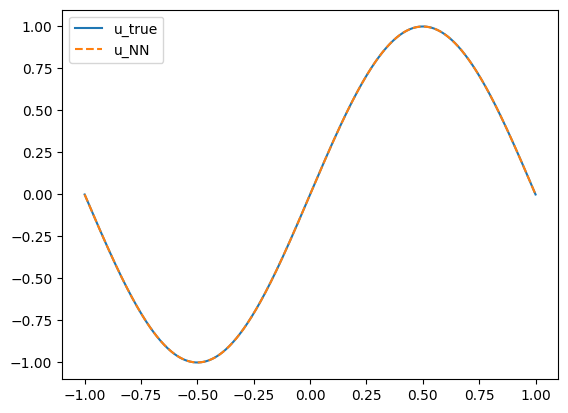

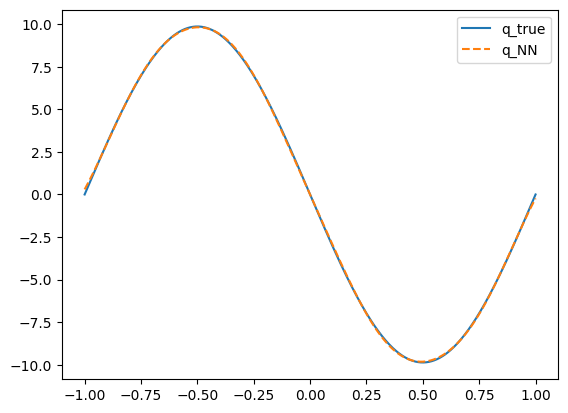

In [13]:
# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]

utrue = np.sin(np.pi * x)
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

qtrue = -np.pi ** 2 * np.sin(np.pi * x)
print("l2 relative error for q: " + str(dde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()

plt.show()